## 모듈 import

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
from matplotlib import rc

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='NanumGothic'
%matplotlib inline 

In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [72]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import joblib

## 파일 불러오기

In [2]:
loan_result_pd = pd.read_csv("../사용데이터/loan_result.csv")
user_spec_pd = pd.read_csv("../사용데이터/user_spec.csv")

#### 컬럼명 한글로 대체

In [3]:
user_spec_DD = pd.read_csv("../사용데이터/user_spec_DD.txt", sep="\t")
user_spec_DD.drop("No.",axis=1,inplace=True)
loan_result_DD = pd.read_csv("../사용데이터/loan_result_DD.txt", sep="\t")
loan_result_DD.drop("No.",axis=1,inplace=True)

user_spec_col = list(user_spec_DD["컬럼명"])
remove_col = {"건강보험타입"}

user_spec_col2 = [i for i in user_spec_col if i not in remove_col]

user_spec_pd.columns=user_spec_col2
loan_result_pd.columns = list(loan_result_DD["컬럼명"])

## 데이터 확인 및 가공

#### 데이트타임 처리

* user_spec

In [4]:
user_spec_pd.insert(0,'일시',pd.to_datetime(user_spec_pd.생성일시))
user_spec_pd.drop("생성일시",axis=1, inplace = True)
user_spec_pd.rename(columns = {"일시":"생성일시"}, inplace = True)
print(0)
user_spec_pd.insert(0, '일', user_spec_pd.생성일시.apply(lambda x: x.day))
print(1)
user_spec_pd.insert(0, '월', user_spec_pd.생성일시.apply(lambda x: x.month))
print(2)

0
1
2


* loan_result

In [5]:
loan_result_pd.insert(0,'일시',pd.to_datetime(loan_result_pd.한도조회일시))
loan_result_pd.drop("한도조회일시", axis=1, inplace = True)
loan_result_pd.rename(columns = {"일시":"한도조회일시"}, inplace = True)
print(0)
loan_result_pd.insert(0, '일', loan_result_pd.한도조회일시.apply(lambda x: x.day))
print(1)
loan_result_pd.insert(0, '월', loan_result_pd.한도조회일시.apply(lambda x: x.month))
print(2)

0
1
2


* user_spec_pd 대출목적 영어와 한글 의미 겹치는거 한글로 통일

In [6]:
kor_list = ["생활비","대환대출","사업자금","기타","전월세보증금","주택구입","투자","자동차구입"]
eng_list = ["LIVING","SWITCHLOAN","BUSINESS","ETC","HOUSEDEPOSIT","BUYHOUSE","INVEST","BUYCAR"]

i=0
for i in range(len(kor_list)):
    user_spec_pd = user_spec_pd.replace({'대출목적': eng_list[i]}, kor_list[i])

**user_spec_pd에서 생일이 입력된적이 있지만 nan으로 되어있는 경우 있음 이를 대체해야함**
* 12961 -> 9724 총 3237개의 데이터 대체가능

In [8]:
user_N_num = user_spec_pd.iloc[user_spec_pd[user_spec_pd['유저생년월일'].isnull()].index,4] #생년월일 NaN이 하나라도 있는 유저 번호 반환
user_num=user_spec_pd.iloc[user_spec_pd[user_spec_pd['유저생년월일'].notnull()].index,4] #생년월일 있는 유저 번호 반환
user_number_all=user_spec_pd['유저번호']



for i in user_N_num :
    if user_spec_pd[user_spec_pd['유저번호']==i]['유저생년월일'].sum() == 0 :
        continue

    else :
        user_spec_pd.iloc[user_spec_pd[user_spec_pd['유저번호']==i].index,5]=user_spec_pd[user_spec_pd['유저번호']==i]['유저생년월일'].mean()
        user_spec_pd.iloc[user_spec_pd[user_spec_pd['유저번호']==i].index,6]=user_spec_pd[user_spec_pd['유저번호']==i]['유저성별'].mean()  

**기대출수가 null이면 다른 경우에도 null이다. 한 유저에 대한 정보가 다르지 않다.**
* 기대출수가 null이면 관련 정보가 없다는 의미이므로 빌린 적이 없다고 받아들여도 무방해 보인다. null은 0으로 대체한다.

In [9]:
user_exp_null = set(user_spec_pd[user_spec_pd["기대출수"].isnull()]["유저번호"])
i=0
for user in user_exp_null:
    if user_spec_pd[user_spec_pd['유저번호'] == user]["기대출수"].sum() == 0:
        continue
    else:
        i+=1
print(i)

0


In [10]:
user_spec_pd["기대출수"].fillna(0, inplace = True)

**기대출금액이 null이면 다른 경우에도 null이다. 한 유저에 대한 정보가 다르지 않다.**
* 기대출금액이 null이면 관련 정보가 없다는 의미이므로 빌린 적이 없다고 받아들여도 무방해 보인다. null은 0으로 대체한다.

In [11]:
user_exp_null = set(user_spec_pd[user_spec_pd["기대출금액"].isnull()]["유저번호"])
i=0
for user in user_exp_null:
    if user_spec_pd[user_spec_pd['유저번호'] == user]["기대출금액"].count() == 0:
        continue
    else:
        i+=1

print(i)

0


In [13]:
user_spec_pd["기대출금액"].fillna(0, inplace = True)

**한도조회당시유저신용점수 null값 처리**
* 8534 명은 이전의 신용점수로 대체가능

In [14]:
user_cred_null = set(user_spec_pd[user_spec_pd["한도조회당시유저신용점수"].isnull()]["유저번호"])

for user in user_cred_null:
    if user_spec_pd[user_spec_pd['유저번호'] == user]["기대출금액"].count() == 0:
        continue
    else:
        user_spec_pd.iloc[user_spec_pd[user_spec_pd['유저번호']==user].index,7]=user_spec_pd[user_spec_pd['유저번호']==user]['한도조회당시유저신용점수'].mean()


* 6월 데이터 분리

In [16]:
#target
user_spec_target = user_spec_pd[user_spec_pd["월"]==6]
loan_result_target = loan_result_pd[loan_result_pd["월"]==6]
#train
user_spec_train = user_spec_pd[user_spec_pd["월"] != 6]
loan_result_train = loan_result_pd[loan_result_pd["월"] != 6]

In [17]:
print(user_spec_target.info())
print(loan_result_target.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364826 entries, 0 to 1394088
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   월             364826 non-null  int64         
 1   일             364826 non-null  int64         
 2   생성일시          364826 non-null  datetime64[ns]
 3   신청서번호         364826 non-null  int64         
 4   유저번호          364826 non-null  int64         
 5   유저생년월일        361683 non-null  float64       
 6   유저성별          361683 non-null  float64       
 7   한도조회당시유저신용점수  346170 non-null  float64       
 8   연소득           364759 non-null  float64       
 9   근로형태          364764 non-null  object        
 10  입사연월          316106 non-null  float64       
 11  고용형태          364764 non-null  object        
 12  주거소유형태        364764 non-null  object        
 13  대출희망금액        364764 non-null  float64       
 14  대출목적          364764 non-null  object        
 15  개인회생자여부       36

**user_spec의 신청서 번호의 중복은 없다 -> loan_result의 신청서 번호와 inner join 가능하다**

In [18]:
print(user_spec_target["신청서번호"].duplicated().sum())
print(user_spec_train["신청서번호"].duplicated().sum())

0
0


user_spec 과 loan_result 합치기

In [19]:
loan_result_target.drop(["월","일","한도조회일시"], axis = 1, inplace = True)
loan_result_train.drop(["월","일","한도조회일시"], axis = 1, inplace = True)

C:\Users\jbhyu\AppData\Local\Temp\ipykernel_39344\102153400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_result_target.drop(["월","일","한도조회일시"], axis = 1, inplace = True)
C:\Users\jbhyu\AppData\Local\Temp\ipykernel_39344\102153400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_result_train.drop(["월","일","한도조회일시"], axis = 1, inplace = True)


In [20]:
user_loan_train = pd.merge(user_spec_train, loan_result_train, left_on = '신청서번호', right_on = '신청서번호', how = 'inner')
user_loan_target = pd.merge(user_spec_target, loan_result_target, left_on = '신청서번호', right_on = '신청서번호', how = 'inner')

In [21]:
print(user_loan_train.isnull().sum(),'\n')
print(user_loan_target.isnull().sum())

월                     0
일                     0
생성일시                  0
신청서번호                 0
유저번호                  0
유저생년월일            77023
유저성별              77023
한도조회당시유저신용점수    1045972
연소득                   0
근로형태                  0
입사연월             303568
고용형태                  0
주거소유형태                0
대출희망금액                0
대출목적                  0
개인회생자여부         5873229
개인회생자납입완료여부     9232232
기대출수                  0
기대출금액                 0
금융사번호                 0
상품번호                  0
승인한도               5625
승인금리               5625
신청여부(타겟)              0
dtype: int64 

월                     0
일                     0
생성일시                  0
신청서번호                 0
유저번호                  0
유저생년월일            30827
유저성별              30827
한도조회당시유저신용점수     256041
연소득                   6
근로형태                  0
입사연월              96758
고용형태                  0
주거소유형태                0
대출희망금액                0
대출목적                  0
개인회생자여부           15470
개인회생자납입완료여부     2561675
기

### 범주형 데이터 확인
Categorical = ["근로형태","고용형태","주거소유형태","대출목적", "유저성별"]

bar plot 그리기
* https://rfriend.tistory.com/411

,타겟0,타겟1,총합,1비율
0.0,4125305,248426,4373731,0.056800
1.0,20468,2583,23051,0.112056


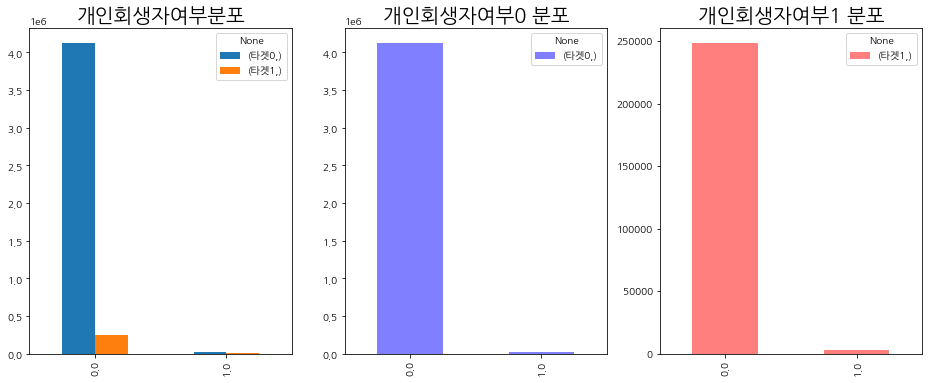

,타겟0,타겟1,총합,1비율
0.0,975276,58387,1033663,0.056486
1.0,3805,311,4116,0.075559


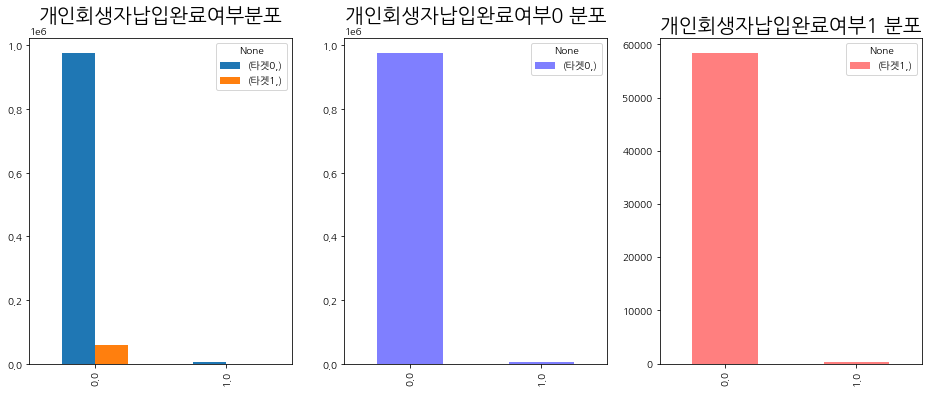

,타겟0,타겟1,총합,1비율
EARNEDINCOME,8336826,378883,8715709,0.043471
EARNEDINCOME2,415571,56178,471749,0.119085
PRIVATEBUSINESS,334117,37931,372048,0.101952
OTHERINCOME,258830,46950,305780,0.153542
FREELANCER,216151,31817,247968,0.128311
PRACTITIONER,148180,8577,156757,0.054715


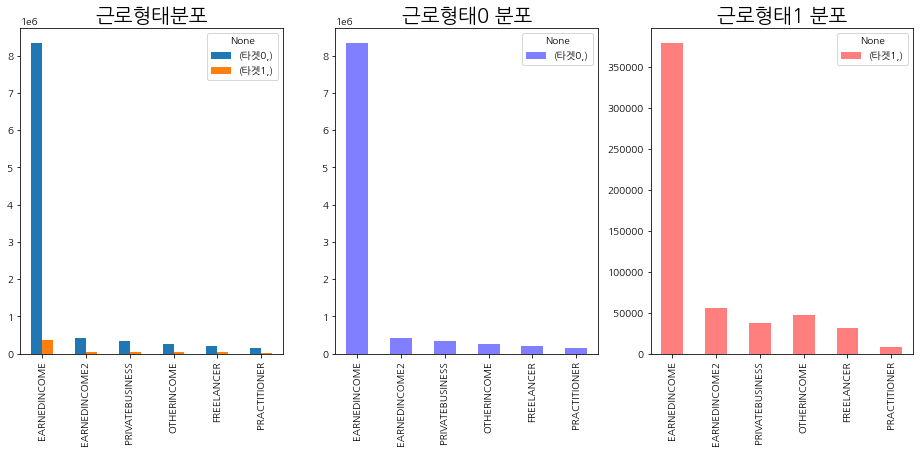

,타겟0,타겟1,총합,1비율
정규직,8013840,384945,8398785,0.045833
계약직,845374,57844,903218,0.064042
기타,724067,105451,829518,0.127123
일용직,126394,12096,138490,0.087342


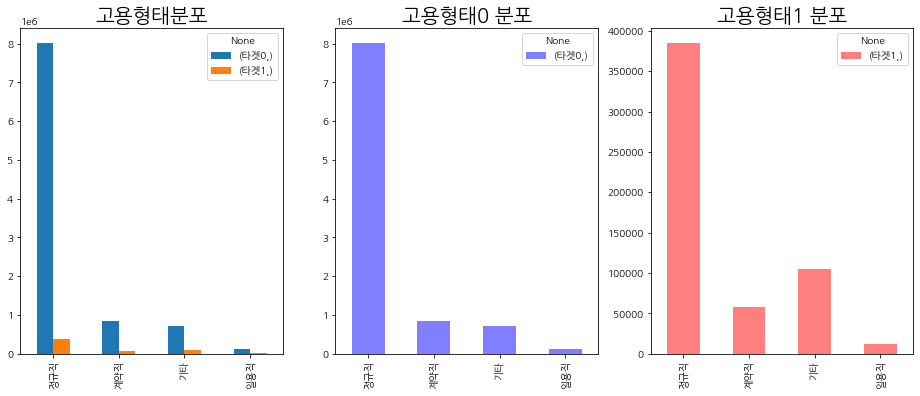

,타겟0,타겟1,총합,1비율
전월세,4340109,254146,4594255,0.055318
자가,2755208,121072,2876280,0.042093
기타가족소유,2602562,184649,2787211,0.066249
배우자,11796,469,12265,0.038239


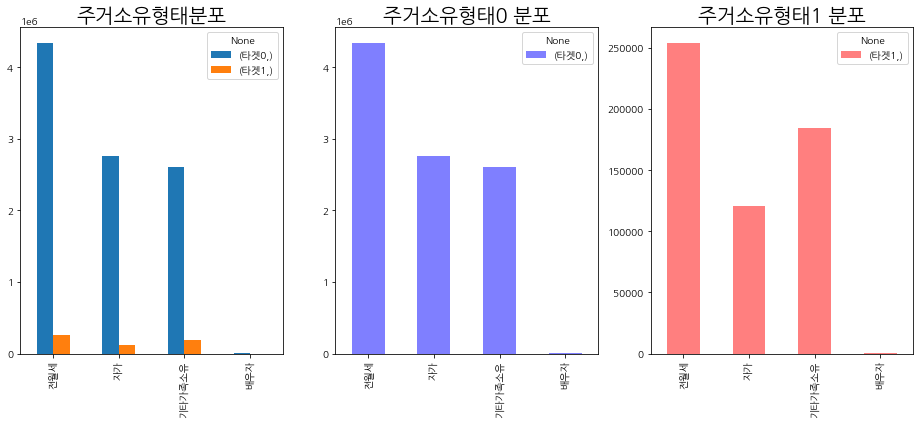

,타겟0,타겟1,총합,1비율
생활비,4888152,375782,5263934,0.071388
대환대출,2969683,129979,3099662,0.041933
주택구입,440558,3512,444070,0.007909
전월세보증금,434869,7682,442551,0.017358
사업자금,402798,23911,426709,0.056036
기타,298618,12635,311253,0.040594
투자,217882,5436,223318,0.024342
자동차구입,57115,1399,58514,0.023909


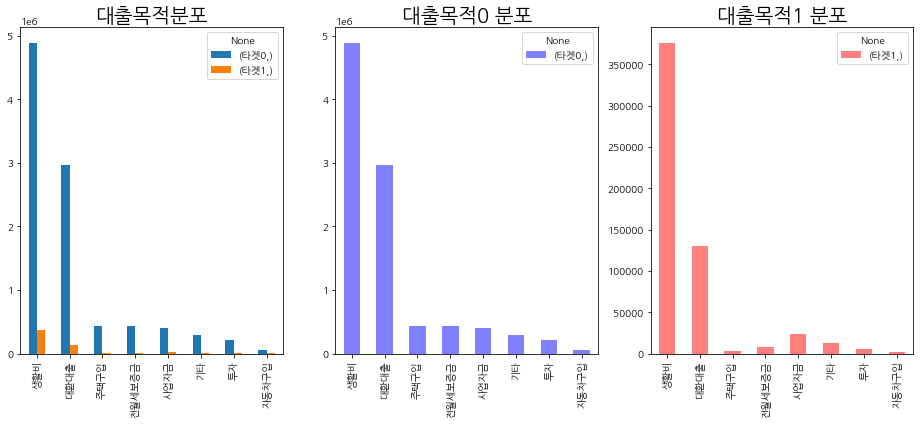

,타겟0,타겟1,총합,1비율
1.0,6695903,372923,7068826,0.052756
0.0,2940450,183712,3124162,0.058804


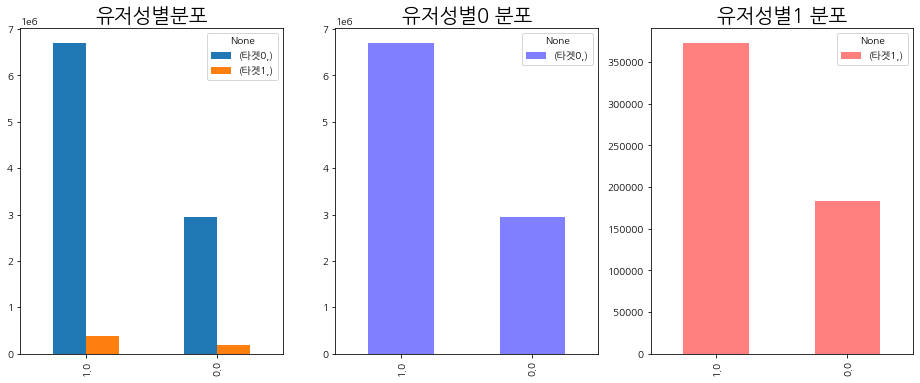

In [22]:
Categorical = ["개인회생자여부","개인회생자납입완료여부","근로형태","고용형태","주거소유형태","대출목적","유저성별"]
#bar_width = 0.5
alpha = 0.5

for cat in Categorical:
    tar_no = pd.DataFrame(user_loan_train[user_loan_train["신청여부(타겟)"]==0][cat].value_counts())
    tar_yes = pd.DataFrame(user_loan_train[user_loan_train["신청여부(타겟)"]==1][cat].value_counts())
    tar_all = pd.concat([tar_no,tar_yes], axis=1)
    tar_all.columns = [["타겟0","타겟1"]]
    #display(tar_all)
    
    f, ax = plt.subplots(1,3, figsize = (16,6))
      
    tar_all.plot(kind = 'bar', ax = ax[0])
    ax[0].set_title(cat+"분포", fontsize = 20)    
    
    tar_all["타겟0"].plot(kind = "bar", ax = ax[1], color = 'b', alpha = alpha)
    ax[1].set_title(cat+" 타겟0 분포", fontsize = 20)

    tar_all["타겟1"].plot(kind = "bar",  ax = ax[2], color = 'r', alpha = alpha)
    ax[2].set_title(cat+" 타겟1 분포", fontsize = 20)
    
    #plot안에 rot = 0 으로 쓰면 xlabel이 가로로 써진다.
    tar_all["총합"] = tar_all["타겟0"].values + tar_all["타겟1"].values
    tar_all["1비율"] = tar_all["타겟1"].values/tar_all["총합"].values
    #tar_all["1비율"]*100
    display(tar_all)

    plt.show()
    

* 범주형 자료들의 경우 target 값에 따라 분포가 약간씩 달라졌다. 일단 모두 get_dummies를 통해 자료형을 바꾸기로 한다.
* 개인회생자 납입완료 여부,성별에 따른 차이는 거의 없다. 이들은 중요한 변수가 아니다 drop하자

In [23]:
def num_plot(column):
  
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))

    sns.histplot(user_loan_train[column],
                ax = axes[0])
    axes[0].tick_params(labelsize=12)
    axes[0].set_title('Full data')
    axes[0].set_ylabel('count')
    
    
    target_0 = user_loan_train[user_loan_train["신청여부(타겟)"]==0][column]
    sns.histplot(target_0, ax = axes[1])
    axes[1].tick_params(labelsize=12)
    axes[1].set_title('target = 0')
    axes[1].set_ylabel('count')
    
    target_1 = user_loan_train[user_loan_train["신청여부(타겟)"]==1][column]
    sns.histplot(target_1, ax = axes[2])
    axes[2].tick_params(labelsize=12)
    axes[2].set_title('target = 1')
    axes[2].set_ylabel('count')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    #plt.show()

    print('타겟 1 데이터의 평균 :', (target_0).mean())
    print('타겟 0 데이터의 평균 :', (target_1).mean())
    print('데이터의 표준오차 :', user_loan_train[column].std() / np.sqrt(user_loan_train[column].count()))

타겟 1 데이터의 평균 : 12.814555801592455
타겟 0 데이터의 평균 : 11.913989987590464
데이터의 표준오차 : 0.0012130727115864876


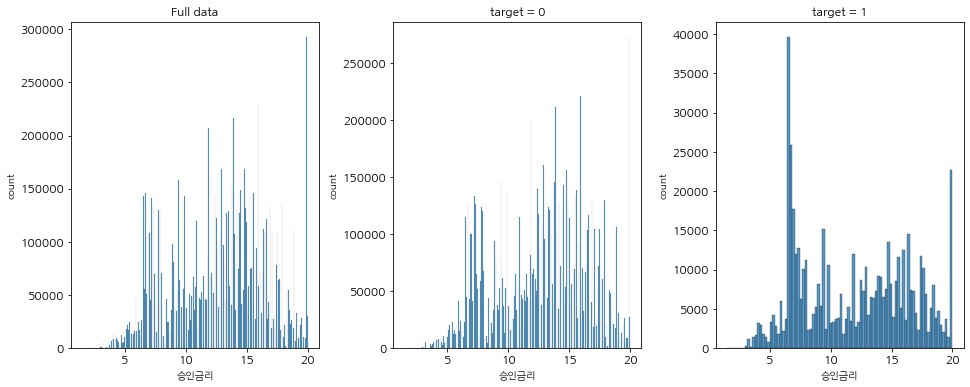

In [24]:
num_plot("승인금리")

* traget이 1일 때랑 0일때 승인금리의 분포는 확실히 다르다.

타겟 1 데이터의 평균 : 755.4783103228356
타겟 0 데이터의 평균 : 657.4865133628084
데이터의 표준오차 : 0.04204428066705293


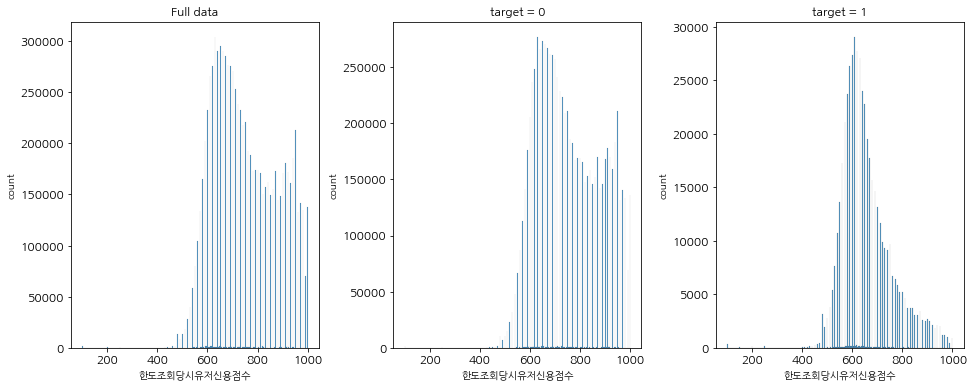

In [43]:
num_plot("한도조회당시유저신용점수")

**생년월일을 이용해 나이 열 추가**

In [47]:
user_loan_train.insert(5, "나이", 2022-user_loan_train["유저생년월일"])

In [211]:
user_loan_target.insert(5, "나이", 2022-user_loan_train["유저생년월일"])

타겟 1 데이터의 평균 : 39.24168894601516
타겟 0 데이터의 평균 : 38.771256430962985
데이터의 표준오차 : 0.003020431759404423


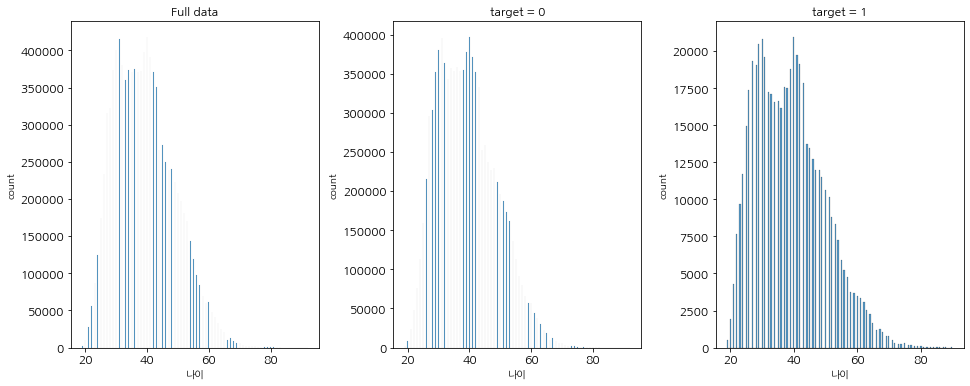

In [49]:
num_plot("나이")

타겟 1 데이터의 평균 : 48115353.70648348
타겟 0 데이터의 평균 : 44573177.74480765
데이터의 표준오차 : 41169.09724216275


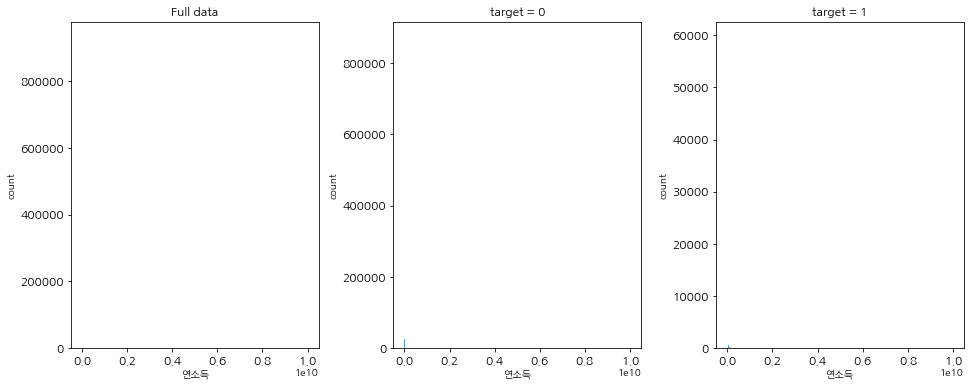

In [50]:
num_plot("연소득")

## 널값 채우기

**승인금리, 승인한도 null인경우 drop하기**

In [38]:
user_loan_train.dropna(subset = ["승인금리","승인한도"], inplace = True)

In [217]:
user_loan_target.dropna(subset = ["승인금리","승인한도"], inplace = True)

**개인회생자여부(null값 0으로 대체)**

In [25]:
regen_null = pd.DataFrame(user_loan_train[user_loan_train["개인회생자여부"].isnull()]["신청여부(타겟)"].value_counts())
display(regen_null)
regen_null_value = regen_null.values
print("target 1의 비율 {}".format(regen_null_value[1]/sum(regen_null_value)))

,신청여부(타겟)
0.0,5563902
1.0,309327


target 1의 비율 [0.05266728]


* target 1의 비율을 근거로 보았을 때 개인회생자여부가 null인 경우 분포는 개인회생자여부가 0인경우와 비슷할 것임이 확인 가능하다.
* null 값을 0으로 채우자

In [26]:
user_loan_train["개인회생자여부"].fillna(0, inplace = True)

In [218]:
user_loan_target["개인회생자여부"].fillna(0, inplace = True)

**한도조회당시유저신용점수 null값 처리(lgbm이용)**

In [31]:
cred_null_user = user_loan_train[user_loan_train["한도조회당시유저신용점수"].isnull()]["유저번호"].values

In [40]:
len(set(cred_null_user))

40227

In [41]:
len(set(user_loan_train["유저번호"].values))

259321

In [107]:
user_loan_train[user_loan_train["한도조회당시유저신용점수"].notnull()].isnull().sum()

월                     0
일                     0
생성일시                  0
신청서번호                 0
유저번호                  0
나이                63635
유저생년월일            63635
유저성별              63635
한도조회당시유저신용점수          0
연소득                   0
근로형태                  0
입사연월             263231
고용형태                  0
주거소유형태                0
대출희망금액                0
대출목적                  0
개인회생자여부               0
개인회생자납입완료여부     8321081
기대출수                  0
기대출금액                 0
금융사번호                 0
상품번호                  0
승인한도                  0
승인금리                  0
신청여부(타겟)              0
dtype: int64

In [114]:
#cred_pred_col = ["연소득","근로형태", "고용형태","기대출수","기대출금액","승인한도","승인금리"]
cred_pred_col = ["연소득","근로형태", "대출목적", "고용형태","기대출수","기대출금액","승인한도","승인금리"]

In [66]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring = 'neg_mean_squared_error',cv=5)
    grid_model.fit(X_train, y_train)
    
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, param정보:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def get_info(model):
    pred = model.predict(X_test).reshape(-1,1)
    y_p = minmax_y.inverse_transform(pred)
    y_p = robust_y.inverse_transform(y_p)
    y_a = minmax_y.inverse_transform(y_test)
    y_a = robust_y.inverse_transform(y_a)
    
    mse = mean_squared_error(y_a,y_p)
    rmse = np.sqrt(mse)
    
    r2 = r2_score(y_a,y_p)
    
    print('{0} RMSE: {1} R2_SCORE: {2}'.format(model.__class__.__name__, np.round(rmse,3), np.round(r2,3)))
    
    y_p = pd.DataFrame(y_p)
    y_a = pd.DataFrame(y_a) 
    
    plt.figure(figsize = (20,10))
    plt.plot(y_a, alpha = 0.2)
    plt.plot(y_p, alpha = 0.5)
    plt.show()
    
    return rmse, r2

* 신용점수예측에 사용되는 열들 중 범주형인 것으로 groupby를 진행한다. (mean)

In [163]:
for_cred_pd2 = pd.concat([user_loan_train,user_loan_target],axis=0).groupby(['유저번호','근로형태','대출목적','고용형태']).mean()

In [165]:
for_cred_pd2 = for_cred_pd2.reset_index()

In [166]:
X_features = for_cred_pd2[for_cred_pd2["한도조회당시유저신용점수"].notnull()][cred_pred_col]
y_target = for_cred_pd2[for_cred_pd2["한도조회당시유저신용점수"].notnull()]["한도조회당시유저신용점수"]

X_features = pd.get_dummies(data = X_features, columns = ["고용형태"])
X_features = pd.get_dummies(data= X_features, columns = ["근로형태"])
X_features = pd.get_dummies(data= X_features, columns = ["대출목적"])

minmax_x = MinMaxScaler()
minmax_y = MinMaxScaler()
robust_x = RobustScaler()
robust_y = RobustScaler()

robust_x.fit(X_features)
robust_y.fit(pd.DataFrame(y_target))

X_features_rb = robust_x.transform(X_features)
y_target_rb = robust_y.transform(pd.DataFrame(y_target))

minmax_x.fit(X_features_rb)
minmax_y.fit(y_target_rb)

X_features_scaled = minmax_x.transform(X_features_rb)
y_target_scaled = minmax_y.transform(y_target_rb)

X_features_scaled = pd.DataFrame(X_features_scaled, columns = X_features.columns)
y_target_scaled = pd.DataFrame(y_target_scaled, columns = ["한도조회당시신용점수"])


In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, y_target_scaled, test_size=0.2, random_state=156)

<AxesSubplot: ylabel='Count'>

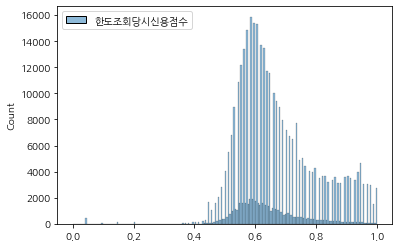

In [168]:
sns.histplot(y_target_scaled)

In [173]:
lgbm_params = {'n_estimators':[1000], 'learning_rate' : [0.01,0.03,0.05]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth = 20, 
                         subsample=0.8, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, device = "gpu")

best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.0798, param정보:{'learning_rate': 0.05, 'n_estimators': 1000}


LGBMRegressor RMSE: 74.468 R2_SCORE: 0.641


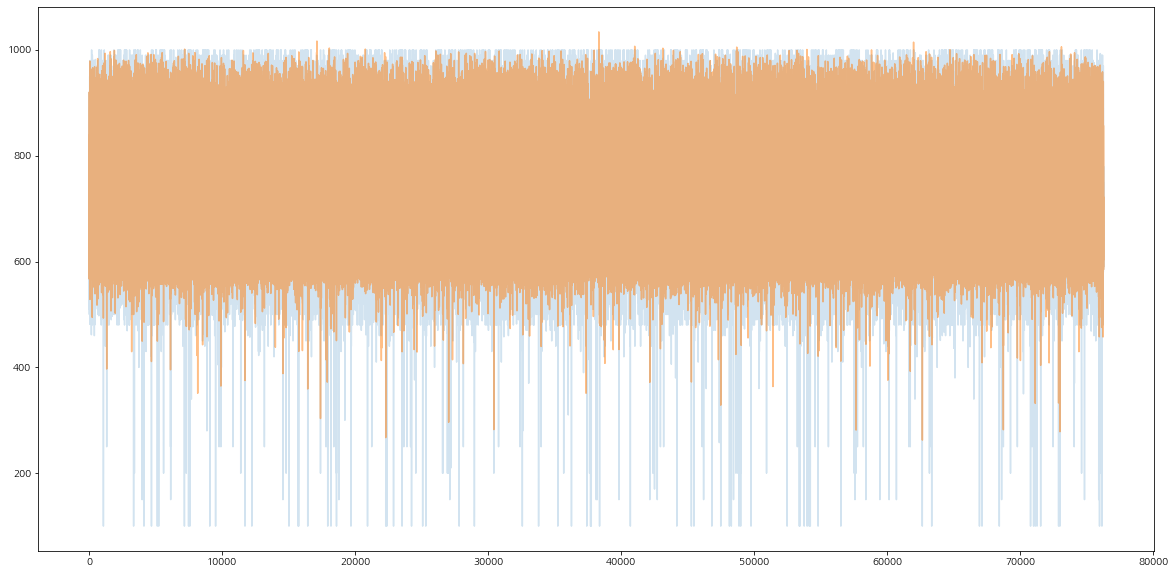

(74.46760559725287, 0.6409952370682341)

In [174]:
get_info(best_lgbm)

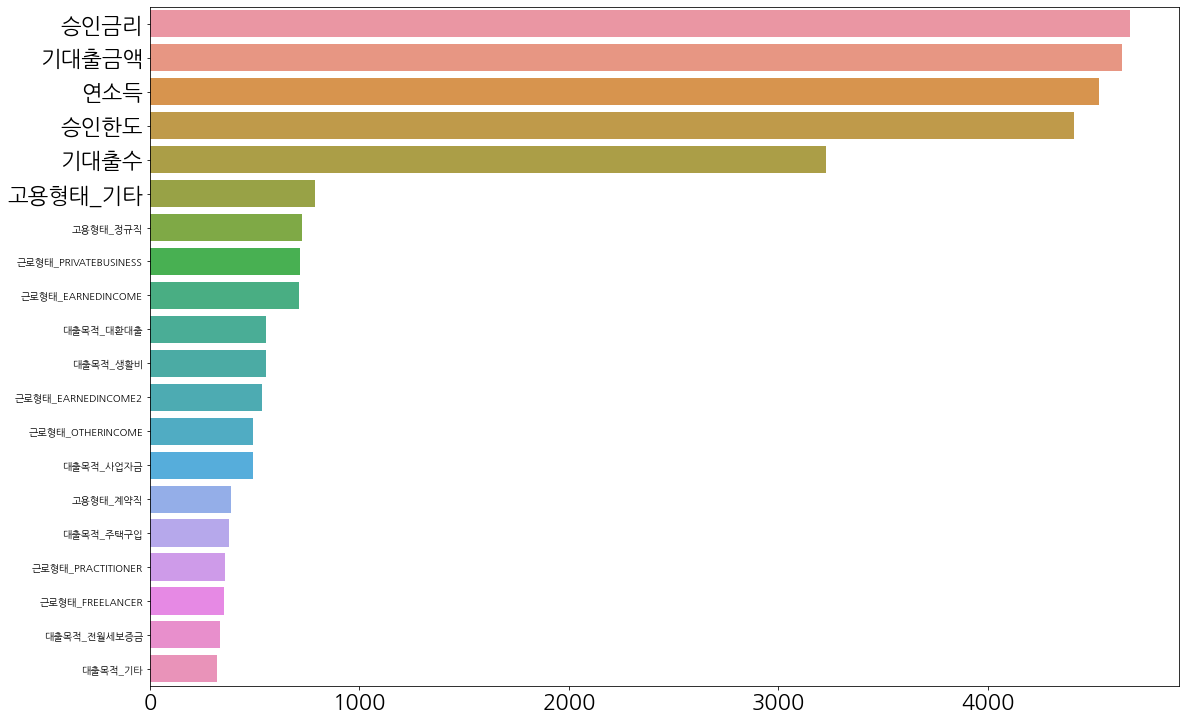

In [175]:
fig, axs = plt.subplots(figsize=(15,10),nrows=1, ncols=1)
fig.tight_layout() 

ftr_top20 = get_top_features(best_lgbm)

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(22)
    sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs)

In [176]:
joblib.dump(best_lgbm,'./cred_lgbm')

['./cred_lgbm']

In [181]:
X_predict_df = for_cred_pd2[for_cred_pd2["한도조회당시유저신용점수"].isnull()][cred_pred_col]
X_predict_df = pd.get_dummies(data = X_predict_df, columns = ["고용형태"])
X_predict_df = pd.get_dummies(data= X_predict_df, columns = ["근로형태"])
X_predict_df = pd.get_dummies(data= X_predict_df, columns = ["대출목적"])

In [183]:
cred_col = X_predict_df.columns

In [184]:
X_predict_df = robust_x.transform(X_predict_df)
X_predict_df = minmax_x.transform(X_predict_df)
X_predict_df = pd.DataFrame(X_predict_df, columns = cred_col) 

In [186]:
pred_df = best_lgbm.predict(X_predict_df).reshape(-1,1)

In [187]:
pred_df = minmax_y.inverse_transform(pred_df)
pred_df = robust_y.inverse_transform(pred_df)

* 예측값의 분포를 보면 실제분포와 비슷함을 볼 수 있다.

<AxesSubplot: ylabel='Count'>

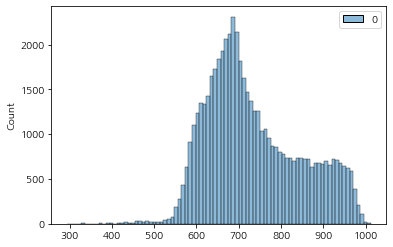

In [189]:
sns.histplot(pred_df)

In [198]:
pred_cred_df = for_cred_pd2[for_cred_pd2["한도조회당시유저신용점수"].isnull()][['유저번호','근로형태','대출목적','고용형태']]
pred_cred_df["한도조회당시유저신용점수예측"] = pred_df.round(1)

In [199]:
pred_cred_df

,유저번호,근로형태,대출목적,고용형태,한도조회당시유저신용점수예측
4,14,EARNEDINCOME,대환대출,정규직,613.9
6,19,OTHERINCOME,생활비,기타,640.2
41,74,EARNEDINCOME,기타,정규직,789.6
42,75,EARNEDINCOME,생활비,정규직,557.2
63,133,OTHERINCOME,생활비,기타,733.6
...,...,...,...,...,...
435386,879634,OTHERINCOME,생활비,기타,686.7
435404,879685,EARNEDINCOME,전월세보증금,정규직,911.6
435405,879688,OTHERINCOME,대환대출,기타,651.6
435411,879695,EARNEDINCOME2,대환대출,정규직,643.3


In [202]:
user_loan_train = pd.merge(user_loan_train, pred_cred_df, how = 'left', left_on =['유저번호','근로형태','대출목적','고용형태'],right_on=['유저번호','근로형태','대출목적','고용형태'])

In [205]:
user_loan_target = pd.merge(user_loan_target, pred_cred_df, how = 'left', left_on =['유저번호','근로형태','대출목적','고용형태'],right_on=['유저번호','근로형태','대출목적','고용형태'])

In [203]:
user_loan_train["한도조회당시유저신용점수"] = np.where(pd.notnull(user_loan_train["한도조회당시유저신용점수"])==True, user_loan_train["한도조회당시유저신용점수"], user_loan_train["한도조회당시유저신용점수예측"])

In [206]:
user_loan_target["한도조회당시유저신용점수"] = np.where(pd.notnull(user_loan_target["한도조회당시유저신용점수"])==True, user_loan_target["한도조회당시유저신용점수"], user_loan_target["한도조회당시유저신용점수예측"])

In [208]:
user_loan_train.drop("한도조회당시유저신용점수예측", axis=1, inplace = True)
user_loan_target.drop("한도조회당시유저신용점수예측", axis=1, inplace = True)

### drop columns = ["유저성별", "입사연월","개인회생자납입완료여부"]

In [213]:
user_loan_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10264386 entries, 0 to 10264385
Data columns (total 25 columns):
 #   Column        Dtype         
---  ------        -----         
 0   월             int64         
 1   일             int64         
 2   생성일시          datetime64[ns]
 3   신청서번호         int64         
 4   유저번호          int64         
 5   나이            float64       
 6   유저생년월일        float64       
 7   유저성별          float64       
 8   한도조회당시유저신용점수  float64       
 9   연소득           float64       
 10  근로형태          object        
 11  입사연월          float64       
 12  고용형태          object        
 13  주거소유형태        object        
 14  대출희망금액        float64       
 15  대출목적          object        
 16  개인회생자여부       float64       
 17  개인회생자납입완료여부   float64       
 18  기대출수          float64       
 19  기대출금액         float64       
 20  금융사번호         int64         
 21  상품번호          int64         
 22  승인한도          float64       
 23  승인금리          float64       
 

In [214]:
user_loan_train.drop(["유저생년월일","유저성별","입사연월","개인회생자납입완료여부"], axis=1, inplace = True)
user_loan_target.drop(["유저생년월일","유저성별","입사연월","개인회생자납입완료여부"], axis=1, inplace = True)

**user_loan_train에는 이제 나이 말고 null을 가지는 열이 없다 csv파일로 내보내자**

In [215]:
user_loan_train.isnull().sum()

월                   0
일                   0
생성일시                0
신청서번호               0
유저번호                0
나이              76988
한도조회당시유저신용점수        0
연소득                 0
근로형태                0
고용형태                0
주거소유형태              0
대출희망금액              0
대출목적                0
개인회생자여부             0
기대출수                0
기대출금액               0
금융사번호               0
상품번호                0
승인한도                0
승인금리                0
신청여부(타겟)            0
dtype: int64

In [220]:
user_loan_train.to_csv("user_loan_train.csv", encoding = 'cp949', index = False)

**user_loan_target에는 연소득에 널값이 있다**

In [219]:
user_loan_target.isnull().sum()

월                     0
일                     0
생성일시                  0
신청서번호                 0
유저번호                  0
나이                23985
한도조회당시유저신용점수          0
연소득                   6
근로형태                  0
고용형태                  0
주거소유형태                0
대출희망금액                0
대출목적                  0
개인회생자여부               0
기대출수                  0
기대출금액                 0
금융사번호                 0
상품번호                  0
승인한도                  0
승인금리                  0
신청여부(타겟)        3255482
dtype: int64

* target에서 연소득이 null인 유저번호는 670502 한명 뿐이다. train 데이터에 유저의 정보는 없다.
* 한도조회당시 신용점수가 매우 높은 것을 확인할 수 있다. 0으로 대체하기엔 무리가 있어보인다. 
* 대출목적이 사업자금인 사람들의 평균으로 대체하자.

In [230]:
user_loan_target[user_loan_target["연소득"].isnull()]

,월,일,생성일시,신청서번호,유저번호,나이,한도조회당시유저신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자여부,기대출수,기대출금액,금융사번호,상품번호,승인한도,승인금리,신청여부(타겟)
1377424,6,30,2022-06-30 21:32:18,341149,670502,53.0,930.0,NaN,OTHERINCOME,기타,기타가족소유,6000000.0,사업자금,0.0,1.0,3000000.0,64,254,45000000.0,10.3,NaN
1377425,6,30,2022-06-30 21:32:18,341149,670502,53.0,930.0,NaN,OTHERINCOME,기타,기타가족소유,6000000.0,사업자금,0.0,1.0,3000000.0,13,262,35000000.0,16.4,NaN
1377426,6,30,2022-06-30 21:32:18,341149,670502,53.0,930.0,NaN,OTHERINCOME,기타,기타가족소유,6000000.0,사업자금,0.0,1.0,3000000.0,38,113,5000000.0,19.5,NaN
1377427,6,30,2022-06-30 21:32:18,341149,670502,53.0,930.0,NaN,OTHERINCOME,기타,기타가족소유,6000000.0,사업자금,0.0,1.0,3000000.0,14,128,15000000.0,12.5,NaN
1377428,6,30,2022-06-30 21:32:18,341149,670502,53.0,930.0,NaN,OTHERINCOME,기타,기타가족소유,6000000.0,사업자금,0.0,1.0,3000000.0,29,265,10000000.0,9.1,NaN
1377429,6,30,2022-06-30 21:32:18,341149,670502,53.0,930.0,NaN,OTHERINCOME,기타,기타가족소유,6000000.0,사업자금,0.0,1.0,3000000.0,57,71,23000000.0,15.4,NaN


In [238]:
user_loan_train[user_loan_train["유저번호"]==670502]

,월,일,생성일시,신청서번호,유저번호,나이,한도조회당시유저신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자여부,기대출수,기대출금액,금융사번호,상품번호,승인한도,승인금리,신청여부(타겟)


In [233]:
m = user_loan_target[user_loan_target["대출목적"] == "사업자금"]["연소득"].mean()
print(m)

60845675.908903316


In [236]:
user_loan_target["연소득"].fillna(round(m,1))

0          30000000.0
1          30000000.0
2          30000000.0
3          30000000.0
4          30000000.0
              ...    
3257154    78000000.0
3257155    78000000.0
3257156    78000000.0
3257157    78000000.0
3257158    78000000.0
Name: 연소득, Length: 3255482, dtype: float64

**이제 타겟데이터에도 나이빼고는 널값이 없으므로 csv파일로 내보낸다.**

In [239]:
user_loan_target.isnull().sum()

월                     0
일                     0
생성일시                  0
신청서번호                 0
유저번호                  0
나이                23985
한도조회당시유저신용점수          0
연소득                   6
근로형태                  0
고용형태                  0
주거소유형태                0
대출희망금액                0
대출목적                  0
개인회생자여부               0
기대출수                  0
기대출금액                 0
금융사번호                 0
상품번호                  0
승인한도                  0
승인금리                  0
신청여부(타겟)        3255482
dtype: int64

In [240]:
user_loan_target.to_csv("user_loan_target.csv", encoding = 'cp949', index = False)